# Interpreting the Linear Regression Training & Validation Data Notebook

This notebook demonstrates how to build, train, and evaluate a linear regression model using PyTorch, with a focus on understanding the effects of different learning rates and the importance of validation data.

---

## 1. Data Preparation

**Custom Dataset:**  
The `Data` class generates synthetic data for a simple linear regression problem (`y = -3x + 1`), with added Gaussian noise.

- **Training Data:** Contains intentional outliers to simulate real-world data imperfections.
- **Validation Data:** No outliers, representing clean data for unbiased evaluation.

**Visualization:**  
The training data (with outliers) and the true function are plotted to show the impact of noise and outliers.

---

## 2. Model Definition

**Linear Regression Model:**  
A simple model is defined using PyTorch's `nn.Module`, with a single linear layer (`nn.Linear`).

---

## 3. Training Setup

**Loss Function:**  
Mean Squared Error (`nn.MSELoss`) is used to measure the difference between predictions and targets.

**DataLoader:**  
The training data is loaded in batches of size 1 (stochastic gradient descent).

**Learning Rates:**  
Multiple learning rates are tested: `[0.0001, 0.001, 0.01, 0.1]`.

**Error Tracking:**  
Tensors are created to store training and validation errors for each learning rate.  
All trained models are saved for later comparison.

---

## 4. Training Loop

For each learning rate:
- A new model and optimizer are created.
- The model is trained for 10 epochs.
- After training, both training and validation losses are computed and stored.
- The trained model is saved.

---

## 5. Results Visualization

**Loss Curves:**  
Training and validation losses are plotted against learning rates (log scale) to visualize which learning rate performs best.

**Model Predictions:**  
Each model's predictions on the validation set are plotted, showing how learning rate affects the fit.

---

## 6. Best Model Selection and Evaluation

**Best Model:**  
The model with the lowest validation error is selected as `good_model`.

**Prediction Comparison:**  
For each sample in the training set, the predicted value (`yhat`) and the actual value (`y`) are printed for direct comparison.

**Scatter Plot:**  
Predicted vs. actual values are plotted for the best model. The closer the points are to the diagonal line, the better the model's predictions.

---

## Key Takeaways

- **Learning Rate Matters:**  
  The choice of learning rate significantly affects model performance and convergence.

- **Validation Data is Crucial:**  
  Using a separate validation set (without outliers) helps identify the best model and prevents overfitting to noisy or outlier-heavy training data.

- **Visualization:**  
  Plotting both the loss curves and the predicted vs. actual values provides insight into model behavior and generalization.

---

**This notebook is a practical guide for experimenting with hyperparameters and understanding the workflow of model selection and evaluation in PyTorch.**

In [1]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim

In [2]:
from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader from PyTorch

class Data(Dataset):  # Define a custom dataset class inheriting from Dataset
    
    # Constructor
    def __init__(self, train=True):  # Optionally specify if this is training data
        self.x = torch.arange(-3, 3, 0.1).view(-1, 1)  # Create input values from -3 to 3 in steps of 0.1, shape (N, 1)
        self.f = -3 * self.x + 1  # True underlying linear function (slope -3, intercept 1)
        self.y = self.f + 0.1 * torch.randn(self.x.size())  # Add Gaussian noise to targets
        self.len = self.x.shape[0]  # Store the number of samples
        
        # Add outliers to training data only
        if train is True:
            self.y[0] = 0  # Set the first target as an outlier
            self.y[50:55] = 20  # Set a block of targets as outliers
        else:
            pass  # No outliers for validation/test data

    # Getter: return a single (input, target) pair by index
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    # Return the total number of samples
    def __len__(self):
        return self.len

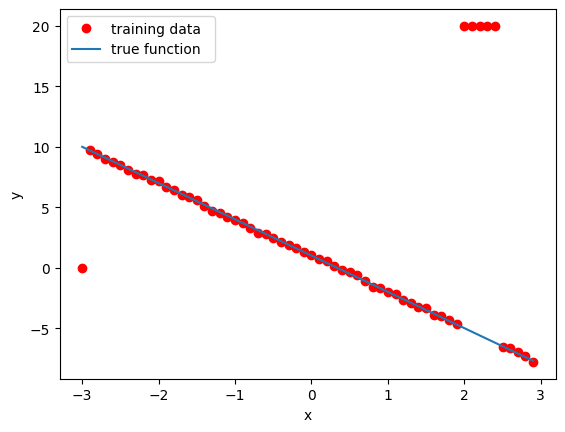

In [4]:
# Create training dataset and validation dataset

train_data = Data()  # Instantiate training dataset (with outliers)
val_data = Data(train=False)  # Instantiate validation dataset (no outliers)

# Plot out training points

plt.plot(train_data.x.numpy(), train_data.y.numpy(), 'or', label="training data ")  # Plot training data as red x's
plt.plot(train_data.x.numpy(), train_data.f.numpy(), label="true function  ")      # Plot the true function as a line
plt.xlabel('x')  # Label x-axis
plt.ylabel('y')  # Label y-axis
plt.legend()     # Show legend
plt.show()       # Display the plot

# Creating a Linear Regression Object Data Loader and Criterion Function


In [5]:
# Create Linear Regression Class

from torch import nn  # Import PyTorch's neural network module

class linear_regression(nn.Module):  # Define a linear regression model inheriting from nn.Module
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()  # Call the parent class constructor
        self.linear = nn.Linear(input_size, output_size)  # Define a linear layer with given input and output size
    
    # Prediction function
    def forward(self, x):
        yhat = self.linear(x)  # Compute the linear transformation
        return yhat  # Return the prediction
    

# Create MSELoss function and DataLoader

criterion = nn.MSELoss()  # Mean Squared Error loss function for regression
trainloader = DataLoader(dataset=train_data, batch_size=1)  # DataLoader for training data with batch size 1

# Creating Multiple Learning Rates and Data Structures to Store Results for Hyperparameters

In [6]:
# Create Learning Rate list, the error lists and the MODELS list

learning_rates = [0.0001, 0.001, 0.01, 0.1]  # List of learning rates to try

train_error = torch.zeros(len(learning_rates))       # Tensor to store training error for each learning rate
validation_error = torch.zeros(len(learning_rates))  # Tensor to store validation error for each learning rate

MODELS = []  # List to store trained models for each learning rate

# Training Models for different Hyperparameters

In [7]:
# Define the train model function and train the model

def train_model_with_lr(iter, lr_list):
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        model = linear_regression(1, 1)  # Create a new linear regression model for each learning rate
        optimizer = optim.SGD(model.parameters(), lr=lr)  # Create SGD optimizer with current learning rate
        for epoch in range(iter):  # Loop over epochs
            for x, y in trainloader:  # Loop over training data
                yhat = model(x)  # Forward pass: compute prediction
                loss = criterion(yhat, y)  # Compute loss
                optimizer.zero_grad()  # Zero gradients
                loss.backward()  # Backpropagate
                optimizer.step()  # Update parameters
                
        # Evaluate on training data
        Yhat = model(train_data.x)  # Predict on all training data
        train_loss = criterion(Yhat, train_data.y)  # Compute training loss
        train_error[i] = train_loss.item()  # Store training loss
    
        # Evaluate on validation data
        Yhat = model(val_data.x)  # Predict on all validation data
        val_loss = criterion(Yhat, val_data.y)  # Compute validation loss
        validation_error[i] = val_loss.item()  # Store validation loss
        MODELS.append(model)  # Save the trained model

train_model_with_lr(10, learning_rates)  # Train models for 10 epochs with each learning rate

# Visualizing the Results

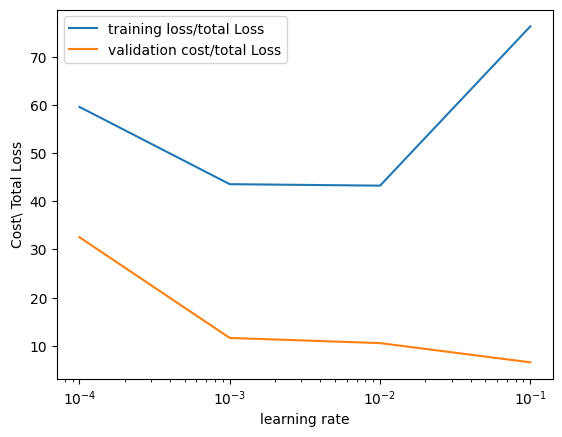

0 [[-0.754628  ]
 [-0.73325104]
 [-0.711874  ]]
1 [[5.773652 ]
 [5.657906 ]
 [5.5421596]]
2 [[6.538201 ]
 [6.40548  ]
 [6.2727585]]
3 [[14.738444]
 [14.293797]
 [13.849147]]


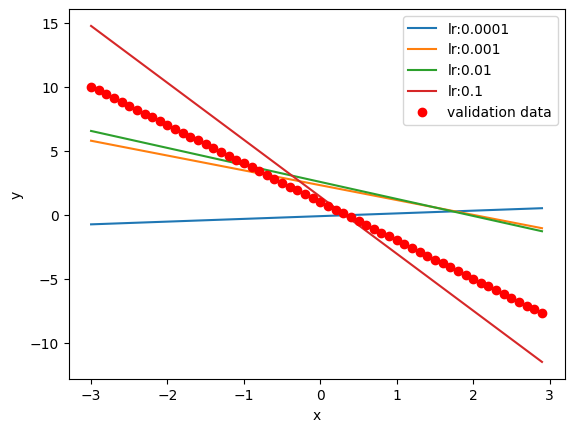

In [8]:
# Plot the training loss and validation loss

plt.semilogx(np.array(learning_rates), train_error.numpy(), label='training loss/total Loss')  # Plot training loss vs learning rate (log scale)
plt.semilogx(np.array(learning_rates), validation_error.numpy(), label='validation cost/total Loss')  # Plot validation loss vs learning rate (log scale)
plt.ylabel('Cost\\ Total Loss')  # Label y-axis
plt.xlabel('learning rate')      # Label x-axis
plt.legend()                    # Show legend
plt.show()                      # Display the plot

# Plot the predictions

i = 0
for model, learning_rate in zip(MODELS, learning_rates):
    yhat = model(val_data.x)  # Predict on validation data
    plt.plot(val_data.x.numpy(), yhat.detach().numpy(), label='lr:' + str(learning_rate))  # Plot model predictions
    print(i, yhat.detach().numpy()[0:3])  # Print first 3 predictions for inspection
    i += 1
plt.plot(val_data.x.numpy(), val_data.f.numpy(), 'or', label='validation data')  # Plot true validation data as red circles
plt.xlabel('x')  # Label x-axis
plt.ylabel('y')  # Label y-axis
plt.legend()     # Show legend
plt.show()       # Display the plot

In [9]:
# Select the best performing model based on validation error
good_model = MODELS[np.argmin(validation_error)]  # Best model (lowest validation error)

# Loop through the training data and print predictions vs actual values
for x, y in trainloader:
    yhat = good_model(x)  # Model prediction for input x
    print("yhat =", yhat.item(), "y =", y.item())  # Print predicted and actual value

yhat = 14.738444328308105 y = 0.0
yhat = 14.29379653930664 y = 9.771482467651367
yhat = 13.849146842956543 y = 9.419452667236328
yhat = 13.404499053955078 y = 8.961386680603027
yhat = 12.95984935760498 y = 8.775702476501465
yhat = 12.515201568603516 y = 8.50256633758545
yhat = 12.070552825927734 y = 8.113301277160645
yhat = 11.625904083251953 y = 7.749507904052734
yhat = 11.181255340576172 y = 7.6517486572265625
yhat = 10.736607551574707 y = 7.257562637329102
yhat = 10.29195785522461 y = 7.15153169631958
yhat = 9.847309112548828 y = 6.656253337860107
yhat = 9.402660369873047 y = 6.451544761657715
yhat = 8.958011627197266 y = 6.033732891082764
yhat = 8.513362884521484 y = 5.829595565795898
yhat = 8.068714141845703 y = 5.57652473449707
yhat = 7.624065399169922 y = 5.070461273193359
yhat = 7.179416656494141 y = 4.6921892166137695
yhat = 6.734767913818359 y = 4.560507297515869
yhat = 6.290119171142578 y = 4.2028584480285645
yhat = 5.845470428466797 y = 3.9478089809417725
yhat = 5.400821685

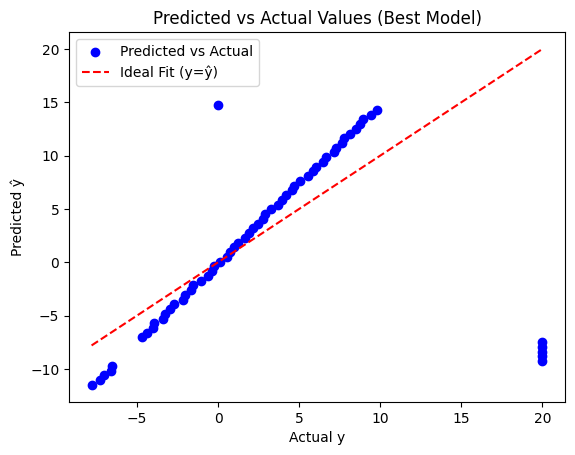

In [10]:
# Plot predicted vs actual values for the best model

yhat_list = []  # Store predictions
y_list = []     # Store actual values

for x, y in trainloader:
    yhat = good_model(x)
    yhat_list.append(yhat.item())
    y_list.append(y.item())

plt.scatter(y_list, yhat_list, color='blue', label='Predicted vs Actual')
plt.plot([min(y_list), max(y_list)], [min(y_list), max(y_list)], 'r--', label='Ideal Fit (y=ŷ)')
plt.xlabel('Actual y')
plt.ylabel('Predicted ŷ')
plt.title('Predicted vs Actual Values (Best Model)')
plt.legend()
plt.show()